## Fairness Analysis of NamSor's Ethnicity API Endpoint using Aequitas

Part I: Fairness of Ethnicity Endpoint by Ethnicity and Gender

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_ethnicity_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,race,race_pred,sex,score,label_value
0,0,1,miguel,hernandez,Other,Hispanic,Male,0.975499,0.0
1,1,3,kevon,dixon,African-American,African-American,Male,0.857965,1.0
2,2,4,ed,philo,African-American,Asian,Male,0.611053,0.0
3,3,5,marcu,brown,African-American,African-American,Male,0.764072,1.0
4,4,6,bouthy,pierrelouis,Other,African-American,Male,0.800832,0.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,race,race_pred,sex,score,label_value
0,1,miguel,hernandez,Other,Hispanic,Male,0.975499,0.0
1,3,kevon,dixon,African-American,African-American,Male,0.857965,1.0
2,4,ed,philo,African-American,Asian,Male,0.611053,0.0
3,5,marcu,brown,African-American,African-American,Male,0.764072,1.0
4,6,bouthy,pierrelouis,Other,African-American,Male,0.800832,0.0


In [5]:
# we only want to look at ethnicity here, since that is what we calculated label_value for
df = df.drop(['race_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
df.shape

(7214, 5)

## Group Metrics

In [7]:
t = 0.8

In [8]:
f_pp = df[((df['race'] == 'African-American') & (df['score'] >= t))]
f_pp.count()

entity_id      1150
race           1150
sex            1150
score          1150
label_value    1150
dtype: int64

In [9]:
f_pn = df[((df['race'] == 'African-American') & (df['score'] < t))]
f_pn.count()

entity_id      2546
race           2546
sex            2546
score          2546
label_value    2546
dtype: int64

In [10]:
f_p = df[((df['race'] == 'African-American') & (df['label_value'] == 1))]
f_p.count()

entity_id      2790
race           2790
sex            2790
score          2790
label_value    2790
dtype: int64

In [11]:
f_n = df[((df['race'] == 'African-American') & (df['label_value'] == 0))]
f_n.count()

entity_id      906
race           906
sex            906
score          906
label_value    906
dtype: int64

In [12]:
f_tn = df[((df['race'] == 'African-American') & (df['score'] < t) & (df['label_value'] == 0) )]
f_tn.count()

entity_id      776
race           776
sex            776
score          776
label_value    776
dtype: int64

In [13]:
f_tp = df[((df['race'] == 'African-American') & (df['score'] >= t) & (df['label_value'] == 1))]
f_tp.count()

entity_id      1020
race           1020
sex            1020
score          1020
label_value    1020
dtype: int64

In [14]:
f_fn = df[((df['race'] == 'African-American') & (df['score'] < t) & (df['label_value'] == 1))]
f_fn.count()

entity_id      1770
race           1770
sex            1770
score          1770
label_value    1770
dtype: int64

In [15]:
f_fp = df[((df['race'] == 'African-American') & (df['score'] >= t) & (df['label_value'] == 0))]
f_fp.count()

entity_id      130
race           130
sex            130
score          130
label_value    130
dtype: int64

In [16]:
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["race", "sex"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.8]}


In [17]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.8_ore,4424,race,African-American,2546,1150,776,1020,130,1770,2790,906,3696,7214
1,0,0.8_ore,4424,race,Asian,10,22,5,21,1,5,26,6,32,7214
2,0,0.8_ore,4424,race,Caucasian,1475,979,488,450,529,987,1437,1017,2454,7214
3,0,0.8_ore,4424,race,Hispanic,115,522,44,520,2,71,591,46,637,7214
4,0,0.8_ore,4424,race,Native American,14,4,14,0,4,0,0,18,18,7214
5,0,0.8_ore,4424,race,Other,264,113,264,0,113,0,0,377,377,7214
6,0,0.8_ore,4424,sex,Female,867,528,321,389,139,546,935,460,1395,7214
7,0,0.8_ore,4424,sex,Male,3557,2262,1270,1622,640,2287,3909,1910,5819,7214


In [18]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.63,0.14,0.89,0.30,0.86,0.37,0.11,0.70,0.58,0.69,0.75
1,race,Asian,0.19,0.17,0.95,0.50,0.83,0.81,0.05,0.50,0.00,0.31,0.81
2,race,Caucasian,0.69,0.52,0.46,0.33,0.48,0.31,0.54,0.67,0.33,0.60,0.59
3,race,Hispanic,0.12,0.04,1.00,0.38,0.96,0.88,0.00,0.62,0.03,0.18,0.93
4,race,Native American,NaN,0.22,0.00,1.00,0.78,NaN,1.00,0.00,0.00,0.78,0.00
5,race,Other,NaN,0.30,0.00,1.00,0.70,NaN,1.00,0.00,0.06,0.70,0.00
6,sex,Female,0.58,0.30,0.74,0.37,0.70,0.42,0.26,0.63,0.20,0.62,0.67
7,sex,Male,0.59,0.34,0.72,0.36,0.66,0.41,0.28,0.64,0.80,0.61,0.67


### Visualize Group Metrics

In [19]:
aq_palette = sns.diverging_palette(225, 35, n=2)
aqp = Plot()

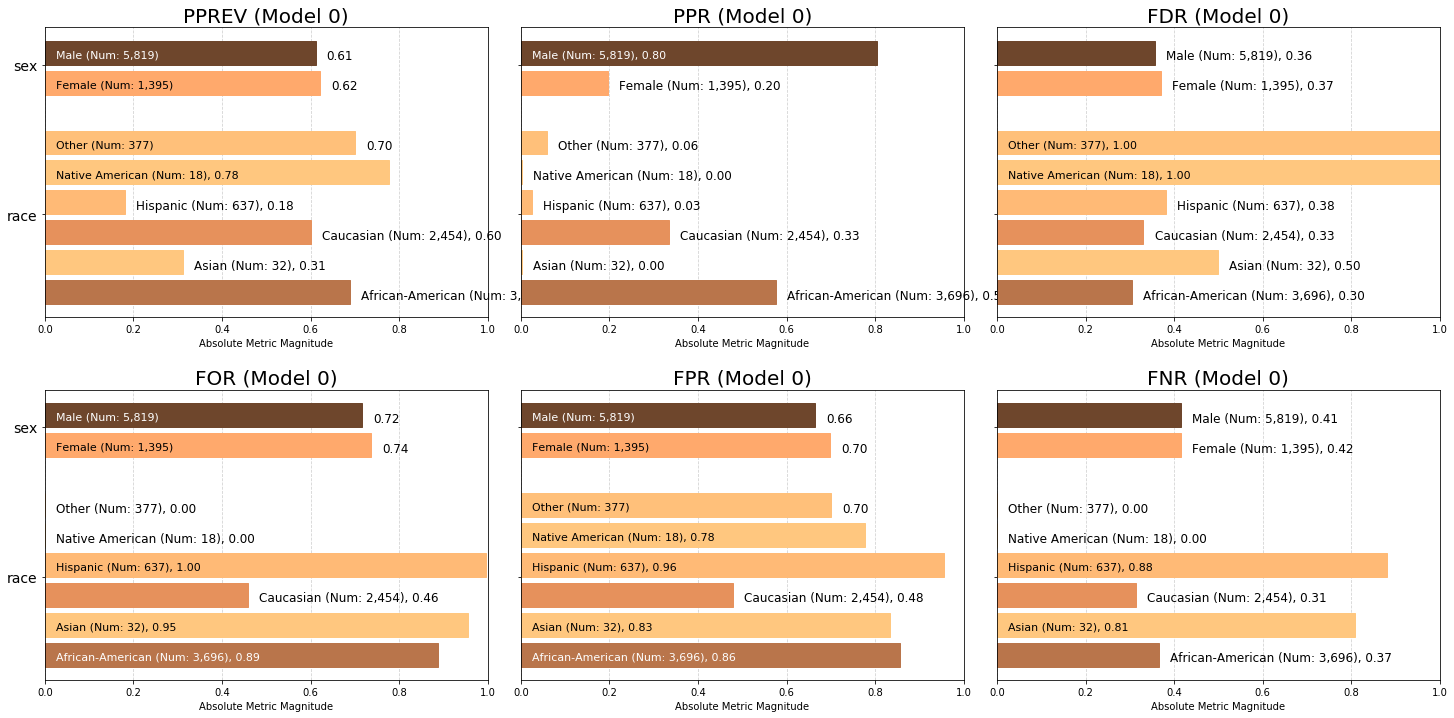

<Figure size 432x288 with 0 Axes>

In [20]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

## Disparities of Group Metrics

In [21]:
b = Bias()
df.head()

,entity_id,race,sex,score,label_value
0,1,Other,Male,0.975499,0.0
1,3,African-American,Male,0.857965,1.0
2,4,African-American,Male,0.611053,0.0
3,5,African-American,Male,0.764072,1.0
4,6,Other,Male,0.800832,0.0


In [22]:
df.dtypes

entity_id        int64
race            object
sex             object
score          float64
label_value    float64
dtype: object

#### Disparities calculated in relation to a user-specified group for each attribute

In [23]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male'}, 
                                        alpha=0.05, check_significance=False, # try with check_significance=True
                                        mask_significance=False)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,0.8_ore,4424,race,African-American,0.634409,0.143488,0.886957,0.304792,0.856512,0.365591,0.113043,0.695208,2546,1150,0.575497,0.688853,776,1020,130,1770,2790,906,3696,7214,0.75487,1.7261,1.14606,1.03894,0.921246,1.92962,1.78499,1.16746,0.923653,0.275855,0.209205,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
1,0,0.8_ore,4424,race,Asian,0.192308,0.166667,0.954545,0.5,0.833333,0.807692,0.0454545,0.5,10,22,0.0022604,0.3125,5,21,1,5,26,6,32,7214,0.8125,0.00677966,0.519915,0.747214,1.51127,2.07667,1.73668,2.57923,0.279986,0.320416,0.084121,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
2,0,0.8_ore,4424,race,Caucasian,0.686848,0.520157,0.459653,0.330847,0.479843,0.313152,0.540347,0.669153,1475,979,0.333409,0.601059,488,450,529,987,1437,1017,2454,7214,0.585575,1,1,1,1,1,1,1,1,1,1,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,0.8_ore,4424,race,Hispanic,0.120135,0.0434783,0.996169,0.382609,0.956522,0.879865,0.00383142,0.617391,115,522,0.0259946,0.180534,44,520,2,71,591,46,637,7214,0.927786,0.0779661,0.300359,0.922647,1.15645,2.16722,1.99341,2.8097,0.174908,0.0835868,0.00709066,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,0.8_ore,4424,race,Native American,nan,0.222222,0,1,0.777778,nan,1,0,14,4,0.00316456,0.777778,14,0,4,0,0,18,18,7214,0,0.00949153,1.29401,0,3.02254,0,1.6209,nan,nan,0.427221,1.85066,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
5,0,0.8_ore,4424,race,Other,nan,0.299735,0,1,0.700265,nan,1,0,264,113,0.0596745,0.700265,264,0,113,0,0,377,377,7214,0,0.178983,1.16505,0,3.02254,0,1.45936,nan,nan,0.576239,1.85066,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
6,0,0.8_ore,4424,sex,Female,0.583957,0.302174,0.736742,0.370242,0.697826,0.416043,0.263258,0.629758,867,528,0.195976,0.621505,321,389,139,546,935,460,1395,7214,0.670251,0.243745,1.01674,0.97947,1.03697,1.02744,1.04949,1.00266,0.998115,0.9018,0.930451,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
7,0,0.8_ore,4424,sex,Male,0.58506,0.335079,0.717065,0.357042,0.664921,0.41494,0.282935,0.642958,3557,2262,0.804024,0.611273,1270,1622,640,2287,3909,1910,5819,7214,0.671765,1,1,1,1,1,1,1,1,1,1,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male


In [24]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,1.7261,1.14606,1.03894,0.921246,1.92962,1.78499,1.16746,0.923653,0.275855,0.209205
1,race,Asian,0.00677966,0.519915,0.747214,1.51127,2.07667,1.73668,2.57923,0.279986,0.320416,0.084121
2,race,Caucasian,1,1,1,1,1,1,1,1,1,1
3,race,Hispanic,0.0779661,0.300359,0.922647,1.15645,2.16722,1.99341,2.8097,0.174908,0.0835868,0.00709066
4,race,Native American,0.00949153,1.29401,0,3.02254,0,1.6209,nan,nan,0.427221,1.85066
5,race,Other,0.178983,1.16505,0,3.02254,0,1.45936,nan,nan,0.576239,1.85066
6,sex,Female,0.243745,1.01674,0.97947,1.03697,1.02744,1.04949,1.00266,0.998115,0.9018,0.930451
7,sex,Male,1,1,1,1,1,1,1,1,1,1


### Visualizing disparities

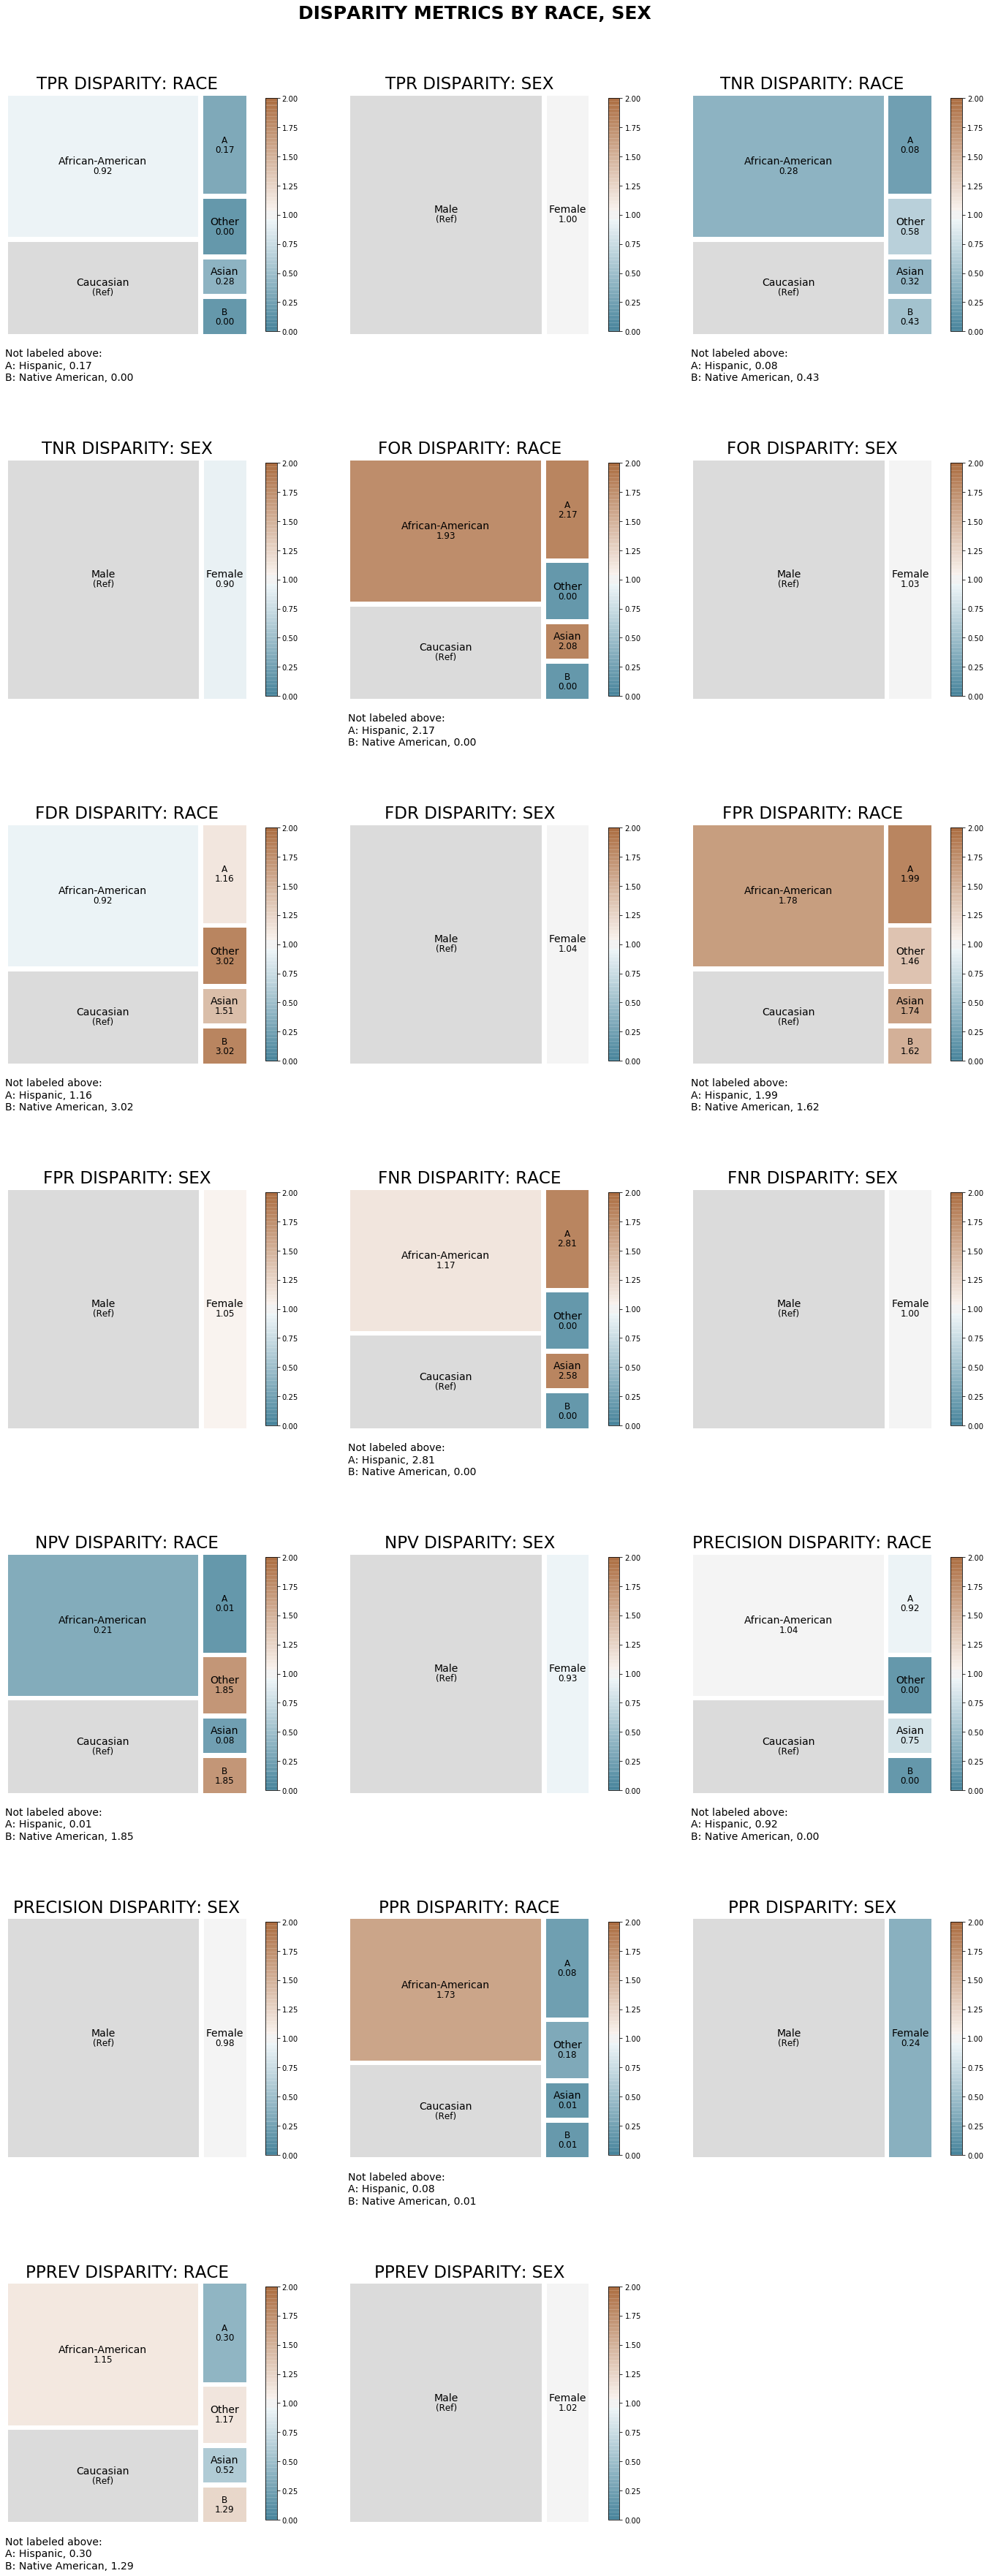

In [25]:
tm_capped = aqp.plot_disparity_all(bdf, attributes=['race', 'sex'], metrics = 'all', significance_alpha=0.05)

## Fairness Metrics

In [26]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [27]:
parity_detrminations = f.list_parities(fdf)

In [28]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,Unsupervised Fairness,TPR Parity,TNR Parity,Supervised Fairness,Statistical Parity,TypeI Parity,FDR Parity,Impact Parity,Precision Parity,FPR Parity,TypeII Parity,NPV Parity,FNR Parity,FOR Parity,Equalized Odds
0,race,African-American,0.634409,0.143488,0.886957,0.304792,0.856512,0.365591,0.113043,0.695208,0.575497,0.688853,0.75487,1.7261,1.14606,1.03894,0.921246,1.92962,1.78499,1.16746,0.923653,0.275855,0.209205,False,True,False,False,False,False,True,True,True,False,False,False,True,False,False
1,race,Asian,0.192308,0.166667,0.954545,0.5,0.833333,0.807692,0.0454545,0.5,0.0022604,0.3125,0.8125,0.00677966,0.519915,0.747214,1.51127,2.07667,1.73668,2.57923,0.279986,0.320416,0.084121,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,0.686848,0.520157,0.459653,0.330847,0.479843,0.313152,0.540347,0.669153,0.333409,0.601059,0.585575,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,0.120135,0.0434783,0.996169,0.382609,0.956522,0.879865,0.00383142,0.617391,0.0259946,0.180534,0.927786,0.0779661,0.300359,0.922647,1.15645,2.16722,1.99341,2.8097,0.174908,0.0835868,0.00709066,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
4,race,Native American,nan,0.222222,0,1,0.777778,nan,1,0,0.00316456,0.777778,0,0.00949153,1.29401,0,3.02254,0,1.6209,nan,nan,0.427221,1.85066,False,nan,False,False,False,False,False,False,False,False,False,False,nan,False,False
5,race,Other,nan,0.299735,0,1,0.700265,nan,1,0,0.0596745,0.700265,0,0.178983,1.16505,0,3.02254,0,1.45936,nan,nan,0.576239,1.85066,False,nan,False,False,False,False,False,True,False,False,False,False,nan,False,False
6,sex,Female,0.583957,0.302174,0.736742,0.370242,0.697826,0.416043,0.263258,0.629758,0.195976,0.621505,0.670251,0.243745,1.01674,0.97947,1.03697,1.02744,1.04949,1.00266,0.998115,0.9018,0.930451,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True
7,sex,Male,0.58506,0.335079,0.717065,0.357042,0.664921,0.41494,0.282935,0.642958,0.804024,0.611273,0.671765,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [29]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,0.8_ore,race,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,0.8_ore,sex,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True


In [30]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Visualize fairness

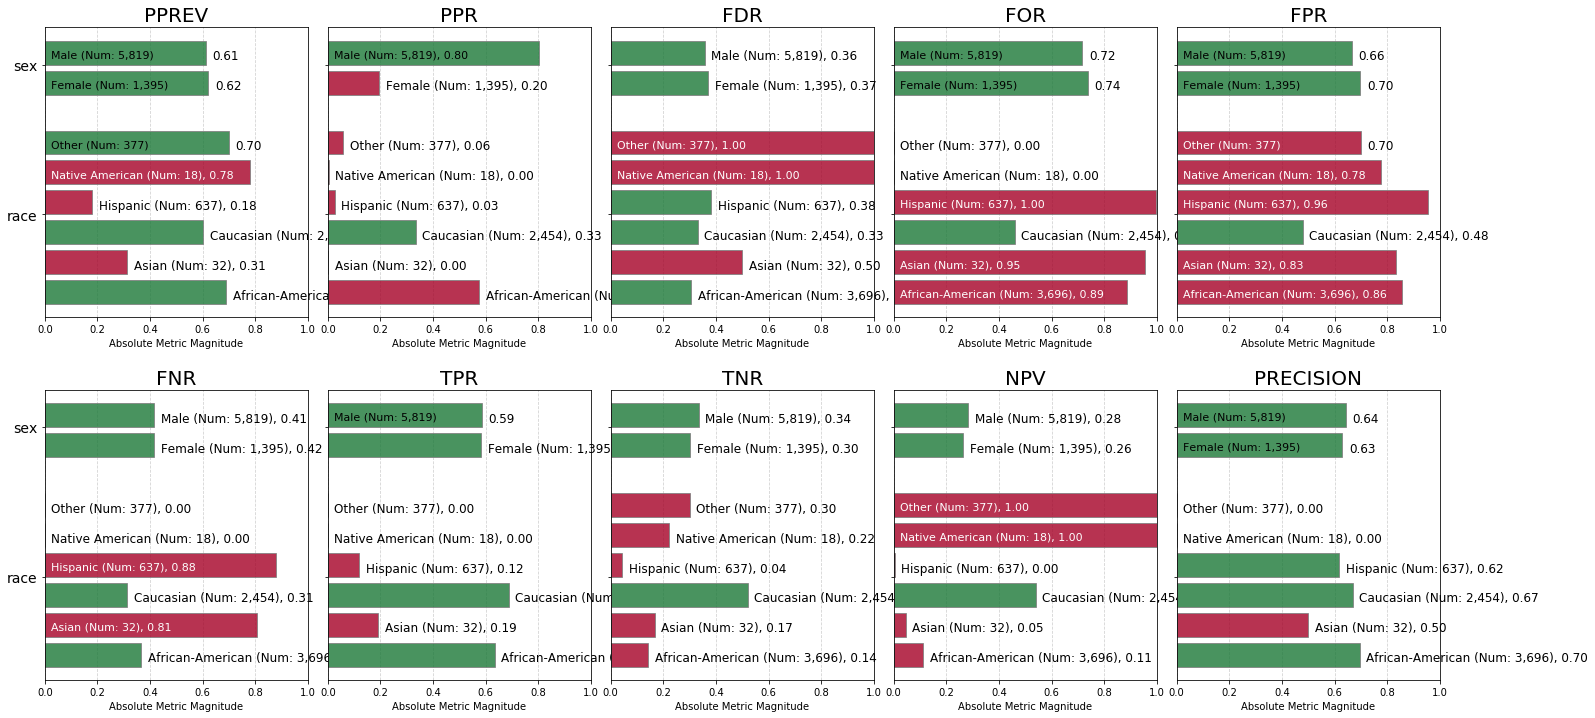

<Figure size 432x288 with 0 Axes>

In [31]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

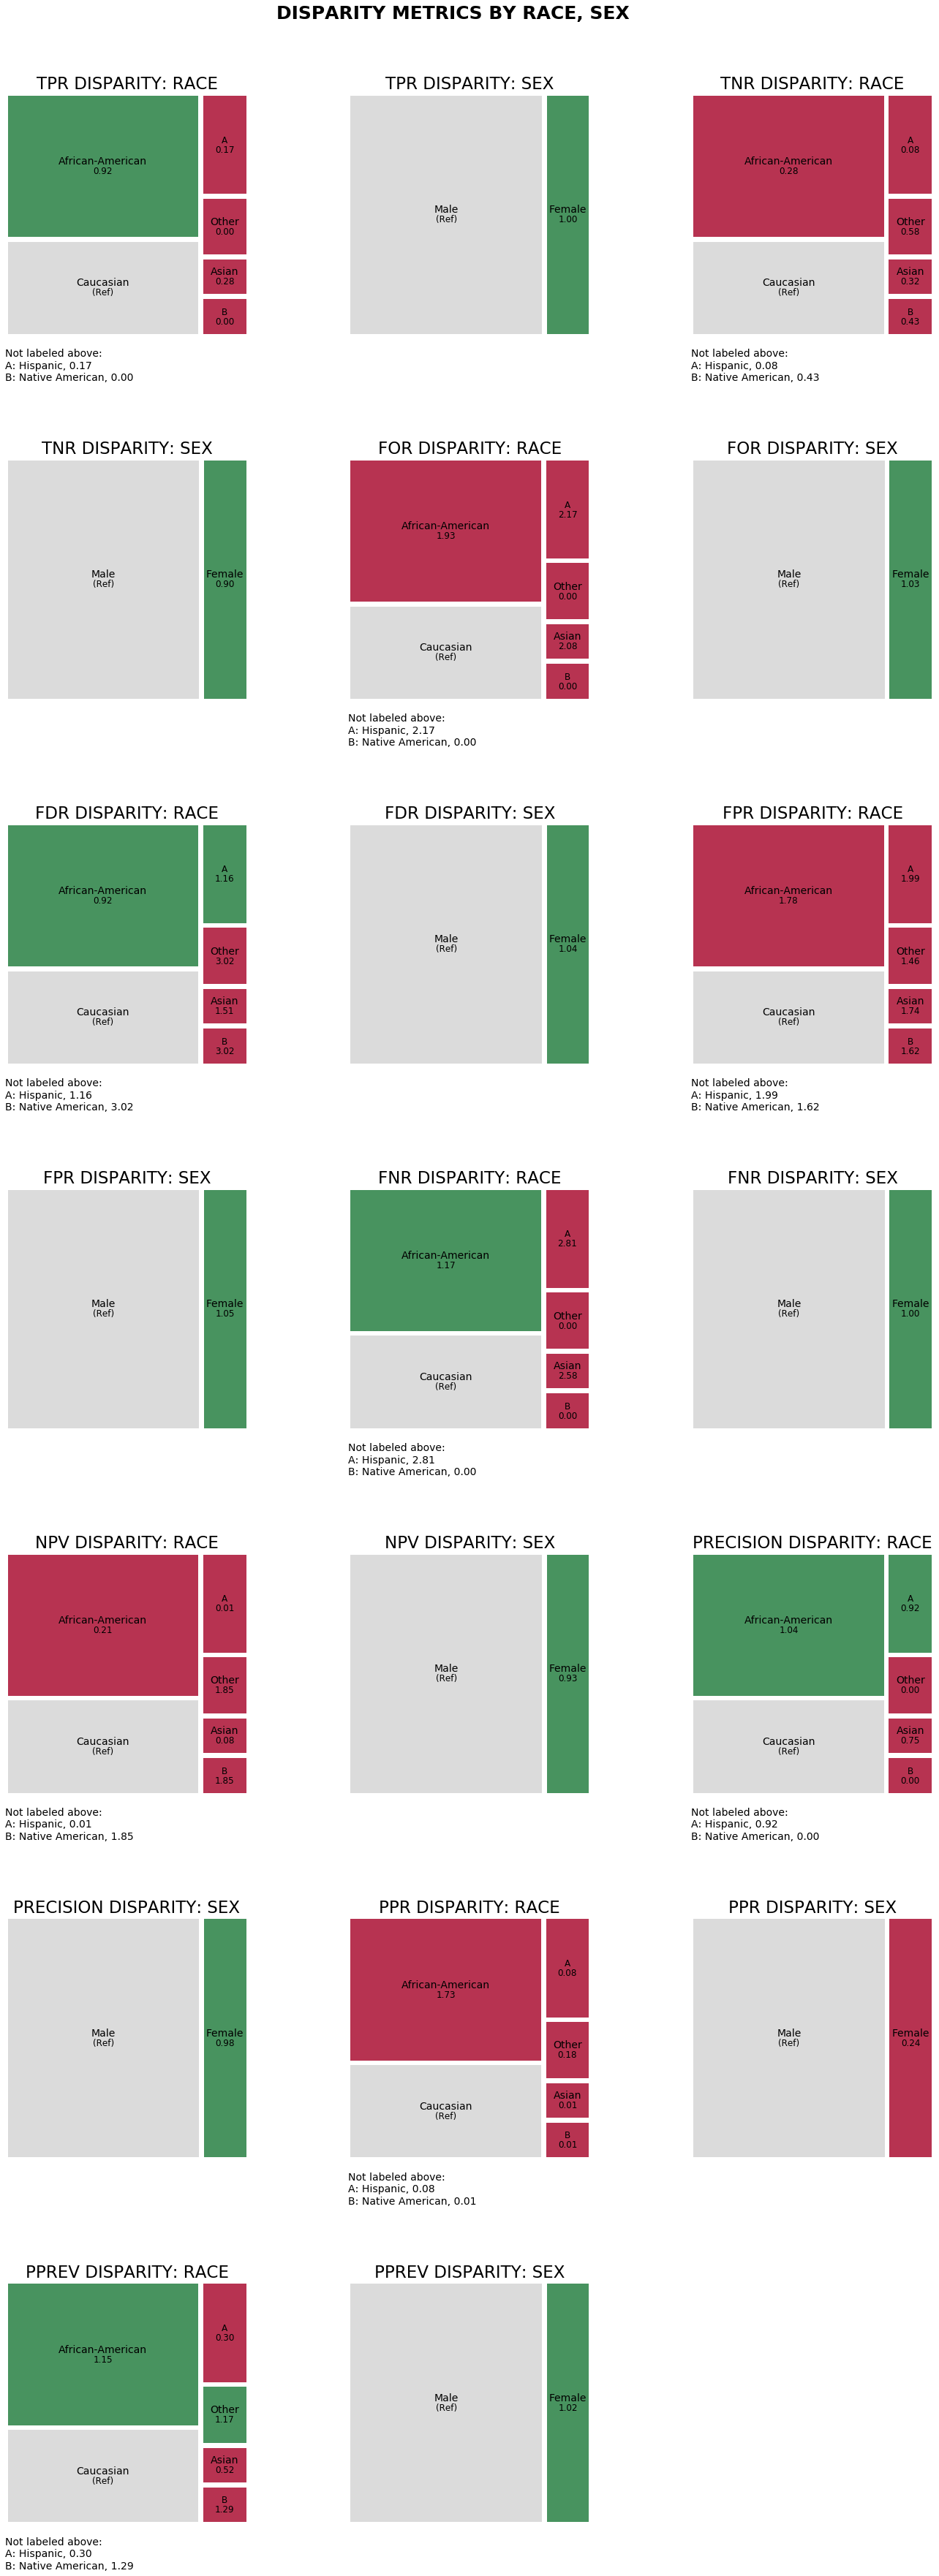

In [32]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['race', 'sex'], metrics='all', 
                                       significance_alpha=0.05)